**Lesson: M931LT1 Artificial Intelligence II**

**Student's name: Christina Christodoulou**

**I.D Number: LT1200027**

**Field of Studies: Language Technology**

**Homework 4**

**Question 1**


**MULTICLASS VACCINE SENTIMENT CLASSIFIER BY FINE-TUNING BERT**

In the present assignment, the basic pretrained **BERT** (**B**idirectional **E**ncoder **R**epresentations from **T**ransformers) model from Hugging Face is fine-tuned for an NLP task, namely **text classification**. The solution is implemented in Pytorch. More specifically, a vaccine sentiment classifier is developed including texts categorized in 3 classes (neutral, anti-vax, pro-vax). The training and validation datasets were provided in csv form containing tweets and their labels, 0 for neutral, 1 for anti-vax and 2 for pro-vax. The validation dataset was copied, renamed as 'vaccine_test _set.csv' and used as the test dataset as well. For the development of the model, I experimented with: 

* the maximum sequence length

* the dropout probability

* the learning rate

* the batch size

* the number of epochs

The precision, recall and F1 score for each class as well as the accuracy of the model is calculated. I also plotted the loss vs epochs and accuracy vs epochs as well as the confusion matrix to check the model’s performance. 

But, why fine-tune a pretrained Bert model and not build another deep learning model? 

**1. Faster model development**

The BERT model was already trained on a huge amount of unlabeled data extracted from BooksCorpus (800 million words) and Wikipedia (2,500 million words), thus it takes much less time (less training epochs) to fine-tune a pretrained model. By adding a simple one-hidden-layer neural network classifier on top of BERT and fine-tuning BERT, state-of-the-art performance can be achieved. 

**2. Bidirectionality**

BERT utilizes the bidirectional nature of the encoder stacks, since it consists of several Transformer encoders stacked together. Each Transformer encoder encapsulates two sub-layers: a self-attention layer and a feed-forward layer. This means that BERT learns information from a sequence of words from both directions. 

**3. Less training data**

Due to its pre-trained weights, the model can be fine-tuned on a much smaller dataset compared to one that would be required in a model that is built from scratch. By fine-tuning BERT, good performance on a smaller training dataset can be achieved. 

**4. Better results**

The fine-tuning procedure offers impressive results on a small dataset for a few training epochs for various NLP tasks. 

**BERT MODEL INPUT AND OUTPUT**

**1.** BERT model input: a sequence of tokens. 2 special tokens for Bert:

 * [CLS] : The first token of every sequence, which stands for classification token.

 * [SEP] : The token that makes BERT know which token belongs to which sequence. This is important for a next sentence prediction task or a question-answering task. In case of one sequence, this token is appended to the end of the sequence. 

 * An input sentence is easily transformed into a sequence of tokens appropriate for BERT by using its tokenizer (BertTokenizer). 

 * Maximum size of tokens: 512. In case the tokens in a sequence are less than 512, padding is used to fill the empty token slots with the [PAD] token. In case the tokens in a sequence are longer than 512, truncation is used.

**2.** BERT model output: an embedding vector of size 768 in each of the tokens. These vectors can be used as an input for different kinds of NLP tasks, like text classification and question-answering that are applied in this assignment.

 * For text classification, the focus is on the embedding vector output from the special [CLS] token. In other words, the embedding vector of size 768 from [CLS] token is used in this assignment as an input for the vaccine classifier, which will output a vector of size 3, which is the number of the classes.

**DOWNLOAD AND IMPORT NECESSARY LIBRARIES AND PACKAGES**

In [1]:
!pip install transformers

     |████████████████████████████████| 3.5 MB 5.4 MB/s 
     |████████████████████████████████| 67 kB 4.5 MB/s 
     |████████████████████████████████| 895 kB 49.2 MB/s 
     |████████████████████████████████| 596 kB 43.2 MB/s 
     |████████████████████████████████| 6.8 MB 27.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
# Import necessary libraries
import torch
import random
import re 
import time
import datetime
import pandas as pd  
import numpy as np
import nltk
import seaborn as sns
import numpy as np
from tqdm import tqdm
import torch.nn as nn
import torchtext
import torchtext.legacy
import torch.nn.functional as F
import matplotlib.pyplot as plt 
from nltk.corpus import stopwords
from sklearn.utils import resample
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import Dataset, TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, get_linear_schedule_with_warmup, BertTokenizer, BertModel

# Download necessary packages
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
stop_words_set = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


**SET UP GPU FOR TRAINING**

In [3]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device('cpu')

There are 1 GPU(s) available.
Device name: Tesla K80


**FUNCTIONS USED**

In [4]:
# A function that sets seed for reproducibility
def set_seed(seed_value): 
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

In [5]:
# A function that calculates time in seconds and returns a string in the form hh:mm:ss
def calculate_time(elapsed_time):
   
    # Round to the nearest second
    elapsed_rounded = int(round((elapsed_time)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [6]:
# A function that opens, reads a file in csv with utf-8 encoding, gets the values, checks and fills empty values and checks for duplicates
def read_explore_dataframe(csv_file):
  
  # Open and read the csv file with utf-8 encoding
  dataframe = pd.read_csv(csv_file, encoding='utf-8')
  
  # Get the keys and their corresponding number of values
  keys = dataframe.keys() 
  for key in keys:
    df_len = len(dataframe[key].unique()) # the length of the unique values of each column
    print('{0:25}{1:10}'.format(key,df_len))

  # Remove missing values and keep the dataFrame with valid entries in the same variable
  dataframe.dropna(inplace=True)
  # Remove the index
  dataframe.reset_index(inplace=True,drop=True)

  dataframe.duplicated() # check for duplicates
  print('Number of duplicates in the dataframe:', dataframe.duplicated().sum())
  # Remove duplicate rows
  dataframe.drop_duplicates()
  print('Dataframe checked for NaN values and duplicates!')
  
  return dataframe 

In [7]:
# A function that takes as parameter a text and applies pre-processing steps to clean it
def text_preprocessing(text):
  
  # Remove tags
  TAG_RE = re.compile(r'<[^>]+>')
  no_tags = TAG_RE.sub('',text)  
                
  # Remove unusual characters
  text = re.sub('<[^>]*>', '', no_tags)

  # Remove urls
  text = re.sub(r'http\S+','', text)
    
  # Remove emoticons
  emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)

  # Convert all words to lowercase
  text = re.sub('[\W]+', ' ', text.lower()) + " ".join(emoticons).replace('-', '')
  
  # Remove numbers
  no_numbers_txt = re.sub(r'\d+', '', text)
  
  # Tokenize
  tokens = nltk.word_tokenize(no_numbers_txt)

  # Remove punctuation
  no_punct = [word for word in tokens if word.isalpha()]

  # Remove stopwords
  words = [w for w in no_punct if not w in stop_words_set]
                
  # Lemmatize
  lemmatizer = WordNetLemmatizer()
  lemmas = " ".join([lemmatizer.lemmatize(word) for word in words])
  
  return lemmas

In [8]:
# A function that gets as input the dataframe and gets the necessary values from the columns after resampling and pre-processing
def get_columns(dataframe, feature, label):
  
  # Get only the columns we are interested in
  dataset = dataframe[[feature,label]]
  
  # Check the distribution of classes
  distribution = dataset[label].value_counts()/dataset.shape[0]
  print('Distribution of data in classes:')
  print(distribution)

  # Separate the different labels and create a combined dataset
  neutral = dataset[dataset[label] == 0]
  antivax = dataset[dataset[label] == 1]
  provax = dataset[dataset[label] == 2]

  # Combine the classes with the greater number of values
  class_majorities = pd.concat([neutral,provax])
  classes = pd.concat([neutral,antivax,provax])

  # Upsampling: take samples with replacement from the minority class until the class is almost the same size as the majorities
  train_minority_upsampled = resample(antivax, replace = True, n_samples = len(classes), random_state = 123)
  train_minority_upsampled2 = resample(neutral, replace = True, n_samples = len(classes), random_state = 123)
  train_minority_upsampled3 = resample(provax, replace = True, n_samples = len(classes), random_state = 123)
  
  # Combine in a new dataframe the new resampled classes 
  dataset = pd.concat([train_minority_upsampled,train_minority_upsampled2,train_minority_upsampled3]) 
  print('Distribution of data in classes after resampling:')
  print(dataset[label].value_counts())
  
  # Apply the pre-processing function to the dataframe containing the text (feature column)
  dataset[feature] = dataset[feature].apply(text_preprocessing)
  print('\nText done pre-processing!')

  # Divide the X and y values
  X = dataset[feature]
  y = dataset[label]

  # Concatenate the X,Y data
  new_dataframe = pd.concat([X, y], axis=1)
     
  return new_dataframe

In [9]:
class Data_Preparation(Dataset):
  
  def __init__(self, tweet, label, tokenizer, max_len):
    
    self.tweet = tweet
    self.label = label
    self.tokenizer = tokenizer
    self.max_len = max_len
        
  def __len__(self):
    
    return len(self.tweet)
    
  def __getitem__(self,index):
   
    tweet = self.tweet[index]
    encoding = self.tokenizer.encode_plus(
        tweet,
        add_special_tokens = True,      # Add [CLS] and [SEP]
        max_length = self.max_len,      # Max length to pad
        padding = 'max_length',         # Pad sentence according to max length
        truncation = True,              # Truncate the sentences
        return_token_type_ids = False,  # Do not return the ids of type tokens
        return_attention_mask = True,   # Return attention mask
        return_tensors = 'pt')          # Return PyTorch tensor

    return {'input_id': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(self.label[index], dtype = torch.long)}

In [10]:
# Calculates the accuracy per batch, used in the train_model and evaluate_model functions 
def accuracy(preds, y_true):
 
  pred_flat = np.argmax(preds, axis=1).flatten()
  labels_flat = y_true.flatten()
  acc = np.sum(pred_flat == labels_flat) / len(labels_flat)
  
  return acc

In [11]:
# A function that plots the confusion matrix with colors and titles 
def show_confusion_matrix(confusion_matrix):
  
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True Labels')
  plt.xlabel('Predicted Labels')

In [12]:
# A function that calculates all the metrics using the validation/test set
def calculate_metrics(y_true, preds):  
  
  print('\nCalculating metrics...')

  preds = preds.detach().cpu().numpy()
  y_true = y_true.to('cpu').numpy()
  
  # Calculate the accuracy of the model 
  acc = accuracy_score(y_true, preds)
  
  # Calculate general precision, recall, F1 score of the model and of each class
  precision, recall, fscore, support = score(y_true, preds)
  print('Accuracy: {}'.format(acc))
  print('Precision: {}'.format(precision))
  print('Recall: {}'.format(recall))
  print('F1 score: {}'.format(fscore))
  print('Support: {}'.format(support))
 
  # Print classification report
  class_names = ['neutral', 'anti-vax', 'pro-vax']
  print(classification_report(y_true, preds, target_names=class_names))

  cm = confusion_matrix(y_true, preds)
  df_cm = pd.DataFrame(cm, index = class_names, columns = class_names)
  show_confusion_matrix(df_cm)

**SET UP THE BERT PRETRAINED MODEL AND ITS TOKENIZER**

In [13]:
# Define the pre-trained model from Hugging Face and its tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name, do_lower_case = True)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

* 'bert-base-uncased': the basic pretrained Bert model version will be used. It is a smaller version and it is computationally efficient. It has 12 layers, 768 hidden states, 12 heads, total 110M parameters.
* 'do_lower_case': Convert everything to lower-case.




In [14]:
class BertClassifier(nn.Module):
  
  def __init__(self, bert_model_name, num_classes, dropout):
    super(BertClassifier, self).__init__()
    
    self.config = {'bert_model_path': bert_model_name,
                    'number of classes': num_classes,
                    'dropout': dropout}
        
    self.bert = BertModel.from_pretrained(bert_model_name)
          
    # Dropout layer
    self.dropout = nn.Dropout(dropout)

     # relu activation function
    self.relu =  nn.ReLU()

    # dense layer 1
    self.linear = nn.Linear(768, 512)

     # dense layer 2 (Output layer)
    self.linear_out = nn.Linear(512, num_classes)
          
    # Dense layer 
    #self.linear = nn.Linear(768, num_classes)
    
    # Softmax activation function
    self.softmax = nn.Softmax(dim = 1)
           
  def forward(self, input_ids, attention_mask):
  
    # pooled_output: the embedding vector of [CLS] token, _: the embedding vectors of all of the tokens in a sequence  
    _, pooled_output = self.bert(input_ids, attention_mask,  return_dict = False) 
    x = self.linear(pooled_output)
    relu_output = self.relu(x)
    dropout_output = self.dropout(relu_output)
    out = self.linear_out(dropout_output)
    output = self.softmax(out)
        
    return output

This is a class initializing a Bert-base model with an additional linear layer on top of it, a dropout layer and the softmax activation function. The additional layer uses the embedding vector of size 768 from the [CLS] token (pooled_output) and first passes it through a dropout layer (dropout_out). Then it generates as output the number of the classes through a linear layer (out). At the end of the linear layer, the output is a vector of size 3 passed from the softmax activation function (output), which corresponds to the three labels (neutral, anti-vax, pro-vax). This is an alternative solution instead of using BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels = 3).                                       

**DATA PREPARATION (TRAIN & VALIDATION SETS)**

In [15]:
# Prepare the training dataset
print('------ Preparing the training dataset... ------')

# Opens, reads, checks for duplicates and removes missing values
df_train  = read_explore_dataframe('vaccine_train_set.csv')

# Preprocess and resample dataset and return a new cleaned one 
train_df = get_columns(df_train, 'tweet', 'label')
  
# Save the testing data into csv format 
train_df.to_csv('/content/train.csv', index = False, header = True, sep ='\t')
print('The training dataset is ready and saved into csv format!')

# Prepare the validation dataset
print('\n------ Preparing the validation dataset... ------')

# Opens, reads, checks for duplicates and removes missing values
df_val = read_explore_dataframe('vaccine_validation_set.csv')

# Preprocess and resample dataset and return a new cleaned one 
valid_df = get_columns(df_val, 'tweet', 'label')
  
# Save the testing data into csv format 
valid_df.to_csv('/content/validation.csv', index = False, header = True, sep ='\t')
print('The validation dataset is ready and saved into csv format!')

------ Preparing the training dataset... ------
Unnamed: 0                    15976
tweet                         15881
label                             3
Number of duplicates in the dataframe: 0
Dataframe checked for NaN values and duplicates!
Distribution of data in classes:
0    0.466825
2    0.403418
1    0.129757
Name: label, dtype: float64
Distribution of data in classes after resampling:
1    15976
0    15976
2    15976
Name: label, dtype: int64

Text done pre-processing!
The training dataset is ready and saved into csv format!

------ Preparing the validation dataset... ------
Unnamed: 0                     2282
tweet                          2276
label                             3
Number of duplicates in the dataframe: 0
Dataframe checked for NaN values and duplicates!
Distribution of data in classes:
0    0.466696
2    0.403593
1    0.129711
Name: label, dtype: float64
Distribution of data in classes after resampling:
1    2282
0    2282
2    2282
Name: label, dtype: int64


In [16]:
# Open and read the new cleaned dataframes 
train_dataframe = pd.read_csv('train.csv', sep ='\t')
valid_dataframe = pd.read_csv('validation.csv', sep ='\t')

# Concatenate the train and validation data
all_tweets = np.concatenate([train_dataframe.tweet.values, valid_dataframe.tweet.values])

# Encode the concatenated data
encoded_tweets = [tokenizer.encode(sent, add_special_tokens=True) for sent in all_tweets]

# Find the maximum length
max_len = max([len(sent) for sent in encoded_tweets])
print('Max length: ', max_len)

Max length:  186


In [17]:
max_length = 186

# Get the texts and their labels from the training and validation data
X_train = train_dataframe.tweet.values
y_train = train_dataframe.label.values

X_val = valid_dataframe.tweet.values
y_val = valid_dataframe.label.values

# Encode the datasets
train_data = Data_Preparation(tweet = X_train,
                              label = y_train,
                              tokenizer = tokenizer,
                              max_len = max_length)

val_data = Data_Preparation(tweet = X_val,
                            label = y_val,
                            tokenizer = tokenizer,
                            max_len = max_length)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32
batch_size = 32

train_dataloader = DataLoader(train_data, sampler = RandomSampler(train_data), batch_size = batch_size)  # Select random batches
val_dataloader = DataLoader(val_data, sampler = SequentialSampler(val_data), batch_size = batch_size) # Pull out batches sequentially

print('Data ready for training and validation with Bert!')

Data ready for training and validation with Bert!


In [18]:
def train_evaluate(model, train_dataloader, valid_dataloader, loss_function, optimizer, scheduler, epochs):
  
  print('Training model in {} sentences and evaluating model in {} sentences...'.format(len(train_dataloader), len(valid_dataloader)))
  # Store losses and accuracies
  training_stats = []

  # Measure the total training and evaluation time
  total_t0 = time.time()

  for epoch in range(0, epochs):
    print('\n======== EPOCH {} / {} ========\n'.format(epoch + 1, epochs))
    print('TRAINING MODEL...') 
    
    # Measure how long the training epoch takes
    t0 = time.time()

    training_loss = 0
    training_acc = 0  
    
    model.train()
    
    for step, batch in enumerate(train_dataloader):

      # Progress update every 214 batches 
      if step % 214 == 0 and not step == 0:
        
        # Calculate elapsed time in minutes
        elapsed = calculate_time(time.time() - t0)
              
        # Report progress
        print(f'Batch {step} of {len(train_dataloader)} | Elapsed time: {elapsed}') 
      
      input_ids = batch['input_id'].to(device)
      attention_masks = batch['attention_mask'].to(device)
      labels = batch['label'].to(device)

      # Zero the gradients
      optimizer.zero_grad()
      
      # Perform forward propagation. Compute the predictions                            
      predictions = model(input_ids, attention_masks)

      # Compute the loss
      loss = loss_function(predictions, labels)

      # Move logits and labels to CPU
      predictions = predictions.detach().cpu().numpy()
      labels = labels.to('cpu').numpy()
      
      # Compute the accuracy
      acc = accuracy(predictions, labels)

       # Perform backward propagation
      loss.backward()
           
      # Clip the gradient value
      nn.utils.clip_grad_norm_(model.parameters(), max_norm = 1.0) # Avoid exploding of gradients
          
      # Use optimizer to take gradient step
      optimizer.step()
      
      # Update the learning rate
      scheduler.step()
          
      training_loss += loss.item()
      training_acc += acc.item()

    train_loss_of_epoch = training_loss / len(train_dataloader)
    train_accuracy_of_epoch = training_acc / len(train_dataloader)
          
    # Measure the epoch training time
    training_time = calculate_time(time.time() - t0)
    
    print('Training epoch time: {} | Train Loss: {:.3f} | Train Acc: {:.2f}%'.format(training_time, train_loss_of_epoch, train_accuracy_of_epoch*100))
    
    print('\nEVALUATING MODEL...')
    
    t0 = time.time()

    model.eval()  

    eval_loss = 0
    eval_acc = 0
    
    # Calculation of gradient not required during evaluation 
    with torch.no_grad():  
    
      for batch in valid_dataloader:
        ids_inputs = batch['input_id'].to(device)
        att_masks = batch['attention_mask'].to(device)
        targets = batch['label'].to(device)
    
        # Perform forward propagation
        outputs = model(ids_inputs, att_masks)
        
        # Compute the loss
        logits = loss_function(outputs, targets)

        # Move logits and labels to CPU
        outputs = outputs.detach().cpu().numpy()
        targets = targets.to('cpu').numpy()

        # Compute the accuracy
        accur = accuracy(outputs, targets)
            
        eval_loss += logits.item()
        eval_acc += accur.item()

    loss_of_epoch_val = eval_loss / len(valid_dataloader)
    accuracy_of_epoch_val = eval_acc / len(valid_dataloader)

    # Measure the validating epoch time
    validation_time = calculate_time(time.time() - t0)

    print('Validation epoch time: {} | Validation Loss: {:.3f} | Validation Acc: {:.2f}%'.format(validation_time, loss_of_epoch_val, accuracy_of_epoch_val*100))

    # Record all statistics from each epoch
    training_stats.append({'Epoch': epoch + 1,
                            'Training Loss': train_loss_of_epoch,
                            'Validation Loss': loss_of_epoch_val,
                            'Training Accuracy': train_accuracy_of_epoch,
                            'Validation Accuracy': accuracy_of_epoch_val,
                            'Training Time': training_time,
                            'Validation Time': validation_time})
  
  print('Training and evaluation process complete!')

  print('Total amount of time: {}'.format(calculate_time(time.time()-total_t0)))

  return training_stats

**PREPARE THE NECESSARY PARAMETERS FOR TRAINING AND EVALUATION**

In [19]:
# Set seed for reproducibility
set_seed(42)    

# Define number of training epochs
epochs = 3

# Define parameters for the class that instantiates the Bert model
num_classes = 3
dropout = 0.5

# Define the Bert pretrained model
model = BertClassifier(model_name, num_classes, dropout).to(device)

# Define the optimizer and its parameters
optimizer = torch.optim.AdamW(model.parameters(), lr = 5e-5, eps = 1e-8)

# Total number of training steps
total_steps = len(train_dataloader) * epochs

# Set up the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

# Define the loss function
loss_function = nn.CrossEntropyLoss().to(device)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


**TRAIN AND EVALUATE BERT MODEL (TRAIN & VALIDATION SETS)**

In [20]:
training_statistics = train_evaluate(model, train_dataloader, val_dataloader, loss_function, optimizer, scheduler, epochs)   

Training model in 1498 sentences and evaluating model in 214 sentences...

======== EPOCH 1 / 3 ========

TRAINING MODEL...
Batch 214 of 1498 | Elapsed time: 0:08:21
Batch 428 of 1498 | Elapsed time: 0:16:41
Batch 642 of 1498 | Elapsed time: 0:25:02
Batch 856 of 1498 | Elapsed time: 0:33:24
Batch 1070 of 1498 | Elapsed time: 0:41:45
Batch 1284 of 1498 | Elapsed time: 0:50:06
Training epoch time: 0:58:27 | Train Loss: 0.859 | Train Acc: 68.40%

EVALUATING MODEL...
Validation epoch time: 0:03:09 | Validation Loss: 0.863 | Validation Acc: 68.58%

======== EPOCH 2 / 3 ========

TRAINING MODEL...
Batch 214 of 1498 | Elapsed time: 0:08:23
Batch 428 of 1498 | Elapsed time: 0:16:45
Batch 642 of 1498 | Elapsed time: 0:25:08
Batch 856 of 1498 | Elapsed time: 0:33:32
Batch 1070 of 1498 | Elapsed time: 0:41:55
Batch 1284 of 1498 | Elapsed time: 0:50:17
Training epoch time: 0:58:39 | Train Loss: 0.741 | Train Acc: 80.86%

EVALUATING MODEL...
Validation epoch time: 0:03:10 | Validation Loss: 0.882 |

**VIEW THE RESULTS FROM TRAINING AND VALIDATION**

In [21]:
# Display floats with two decimal places
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics
df_stats = pd.DataFrame(data = training_statistics)

# Use the 'epoch' as the row index
df_stats = df_stats.set_index('Epoch')

# Display the table
df_stats

,Training Loss,Validation Loss,Training Accuracy,Validation Accuracy,Training Time,Validation Time
Epoch,,,,,,
1,0.86,0.86,0.68,0.69,0:58:27,0:03:09
2,0.74,0.88,0.81,0.66,0:58:39,0:03:10
3,0.69,0.86,0.86,0.69,0:58:31,0:03:10


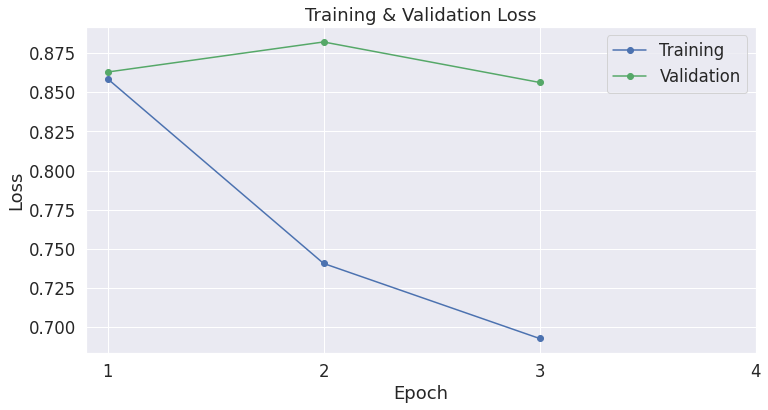

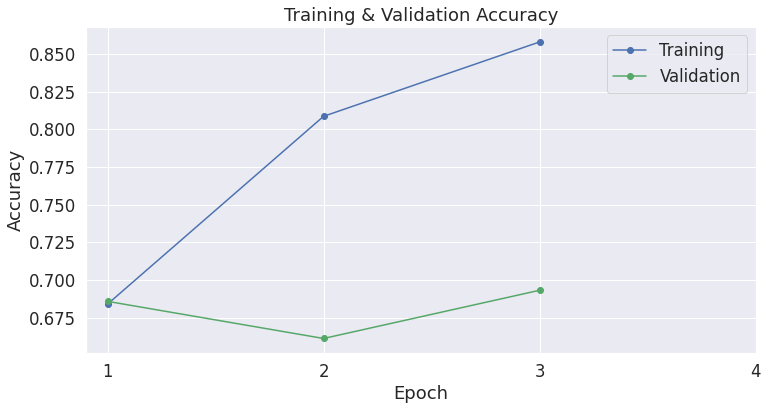

In [22]:
# Use plot styling from seaborn
sns.set(style='darkgrid')

# Increase the plot size and font size
sns.set(font_scale=1.5)
plt.rcParams['figure.figsize'] = (12,6)

# Plot the learning curve of loss
plt.plot(df_stats['Training Loss'], 'b-o', label='Training')
plt.plot(df_stats['Validation Loss'], 'g-o', label='Validation')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.xticks([1, 2, 3, 4])
plt.show()

# Plot the learning curve of accuracy
plt.plot(df_stats['Training Accuracy'], 'b-o', label='Training')
plt.plot(df_stats['Validation Accuracy'], 'g-o', label='Validation')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.xticks([1, 2, 3, 4])
plt.show()

**SAVE THE FINE-TUNED MODEL**

In [23]:
torch.save(model, 'fine_tuned_BERT_model.pt')

**LOAD THE SAVED MODEL**

In [24]:
model = torch.load('fine_tuned_BERT_model.pt')

**PREPARE THE TEST SET**

In [25]:
# Prepare the testing dataset
print('\n------ Preparing the testing dataset... ------')

# Opens, reads, checks for duplicates and removes missing values
# HERE YOU CAN CHANGE THE NAME OF THE INPUT CSV 
df_test = read_explore_dataframe('vaccine_test_set.csv')

# Preprocess and resample dataset and return a new cleaned one 
test_df = get_columns(df_test, 'tweet', 'label')
  
# Save the testing data into csv format 
test_df.to_csv('test.csv', index = False, header = True, sep ='\t')
print('The test dataset is ready and saved into csv format!')


------ Preparing the testing dataset... ------
Unnamed: 0                     2282
tweet                          2276
label                             3
Number of duplicates in the dataframe: 0
Dataframe checked for NaN values and duplicates!
Distribution of data in classes:
0    0.47
2    0.40
1    0.13
Name: label, dtype: float64
Distribution of data in classes after resampling:
1    2282
0    2282
2    2282
Name: label, dtype: int64

Text done pre-processing!
The test dataset is ready and saved into csv format!


In [26]:
# Define the pre-trained model from Hugging Face and its tokenizer
#tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case = True)

In [30]:
test_dataframe = pd.read_csv('test.csv', sep ='\t')

max_length = 186
batch_size = 32

X_test = test_dataframe.tweet.values
y_test = test_dataframe.label.values

test_data = Data_Preparation(tweet = X_test,
                            label = y_test,
                            tokenizer = tokenizer,
                            max_len = max_length)

test_dataloader = DataLoader(test_data, sampler = SequentialSampler(test_data), batch_size = batch_size) # Pull out batches sequentially
print('Data ready for testing the Bert model!')

Data ready for testing the Bert model!


**MODEL EVALUATION ON THE TEST SET**

In [28]:
def test(model, test_dataloader):
    
  print('Predicting labels for {} test sentences...'.format(len(test_dataloader)))
  
  # Initialize empty lists to store the true values and the predicted values
  true_labels = []
  predictions = []
    
  model.eval()

  with torch.no_grad():
    
    for batch in tqdm(test_dataloader):
      mask = batch['attention_mask'].to(device)
      input_id = batch['input_id'].to(device)
      label = batch['label'].to(device)
      
      # Get the predictions
      output = model(input_id, mask)   
      
      # Change the predictions into one dimensional torch tensor
      _, preds = torch.max(output, dim=1)

      # Fill the empty lists with the true values and the predicted values
      predictions.extend(preds)
      true_labels.extend(label)

  real_values = torch.stack(true_labels).cpu()
  predictions = torch.stack(predictions).cpu()

  # Calculate the metrics to evaluate model performance
  calculate_metrics(real_values, predictions)

  return true_labels, predictions

**EVALUATE BERT MODEL (TEST SET)**

Predicting labels for 214 test sentences...


100%|██████████| 214/214 [03:03<00:00,  1.17it/s]



Calculating metrics...
Accuracy: 0.6931054630441134
Precision: [0.75515695 0.78973105 0.59362416]
Recall: [0.73794917 0.56617003 0.7751972 ]
F1 score: [0.7464539  0.65952016 0.67236792]
Support: [2282 2282 2282]
              precision    recall  f1-score   support

     neutral       0.76      0.74      0.75      2282
    anti-vax       0.79      0.57      0.66      2282
     pro-vax       0.59      0.78      0.67      2282

    accuracy                           0.69      6846
   macro avg       0.71      0.69      0.69      6846
weighted avg       0.71      0.69      0.69      6846



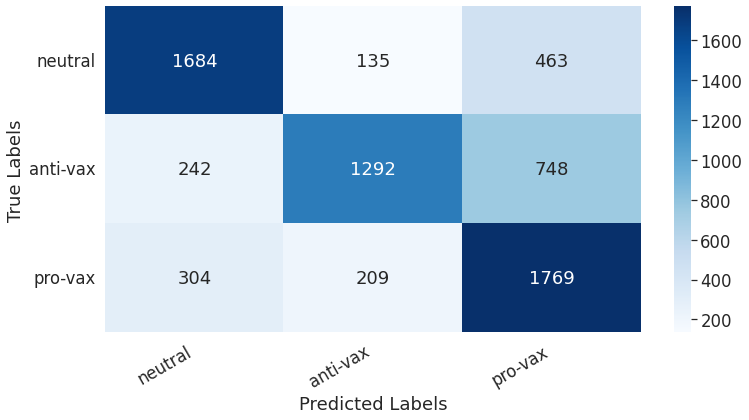

In [31]:
real_labels, predicted_labels = test(model, test_dataloader)